In [1]:
import os
import joblib
import tqdm
#from tqdm import tqdm_notebook as tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import joblib
from API.utils import *
os.listdir('./model')

['eva.pkl',
 'transformer(23_to_54).pkl',
 'ANN(energy).pkl',
 'OperationOptimModel.pkl',
 'transformer(33_to_15).pkl',
 'transformer(54_to_23).pkl',
 'ANN(tray).pkl',
 'transformer(SP162_to_Y162).pkl',
 'transformer(54_to_33).pkl',
 'ANN(58_to_sp162).pkl',
 'transformer(43_to_33).pkl',
 'SVR(4_to_23).pkl']

# 英文記號對應一覽

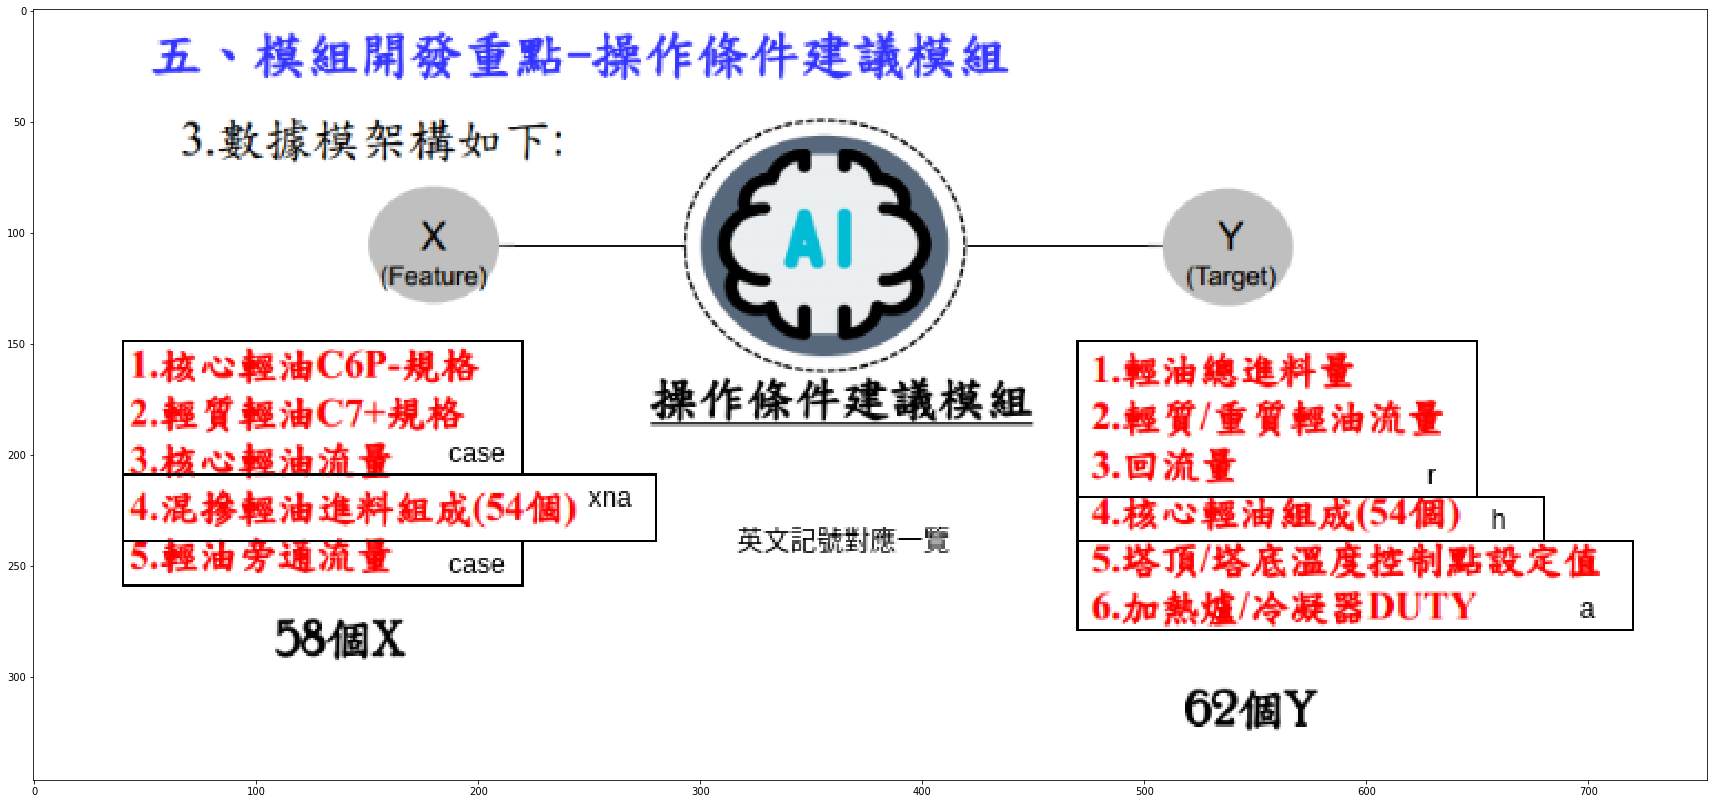

In [2]:
image = mpimg.imread("./img/英文記號對應一覽.png")
plt.figure(figsize = (30,30))
plt.imshow(image)
plt.show()

# load data

In [3]:
col_names = joblib.load('./data/phase_2/cleaned/col_names.pkl')

In [4]:
data = pd.read_csv('./data/phase_2/cleaned/train.csv',index_col=0).sample(1)
case = data[col_names['case']]
xna = data[col_names['xna']]
case

,Case Conditions_Feed Rate to C013 (Input)_m3/hr,Case Conditions_C7+ in Light End (Input)_wt%,Case Conditions_Heart Cut Prod. Rate (Input)_m3/hr,Case Conditions_C6P- in Heart Cut (Input)_wt%
323-17,20.0,5.0,100.0,2.0


# 27種不同規格組合

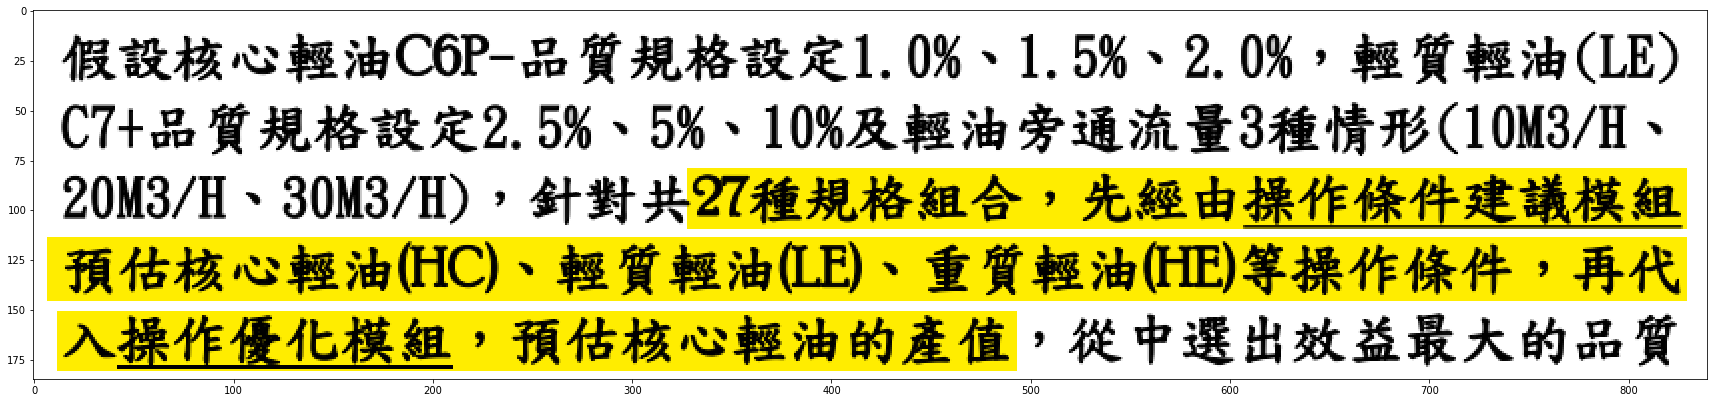

In [5]:
image = mpimg.imread("./img/規格組合n種.png")
plt.figure(figsize = (30,30))
plt.imshow(image)
plt.show()

In [6]:
from copy import deepcopy
'''
case_list = ['組合1','組合2'....'組合n']
'''
case_list = []
for i in [1.0,1.5,2.0]:
    for j in [2.5,5,10]:
        for k in [10,20,30]:
            for v in [90,100,110]:
                case.iloc[0,:] = [k,j,v,i]
                case_list.append(deepcopy(case))

# 從各成份分離係數跟各成份出料比例反推核心和總量的比例 數學推導和驗證

# $\dfrac {F_{hc}x_{hc}}{F_{na}x_{na}}=S_{hc}$

# $\dfrac {F_{hc}}{F_{na}}=\dfrac {X_{na}S_{hc}}{X_{hc}}$

In [7]:
a = data[col_names['fhc']].values[0]/data[col_names['fna']].values[0]
a

array([0.78634675])

In [8]:
xna_ = data[col_names['xna']].values
xhc_ = data[col_names['xhc']].values
shc_ = data[col_names['shc']].values
b = (xna_@shc_.T)/xhc_.sum(axis=1)
b

array([[0.78634675]])

In [9]:
assert (a-b.ravel()[0]< 1e-12)[0]

# load model(之前就訓練好的模型)

In [10]:
m58_162 = joblib.load('./model/ANN(58_to_sp162).pkl')#分離係數模組
m162_162 = joblib.load('./model/transformer(SP162_to_Y162).pkl')#從分離係數還原組成
m54_33 = joblib.load('./model/transformer(54_to_33).pkl')#54轉33
m43_33 = joblib.load('./model/transformer(43_to_33).pkl')#10+33轉33(重組油預測模組)
m33_15 = joblib.load('./model/transformer(33_to_15).pkl')#33轉15(矩陣轉換)
m54_23 = joblib.load('./model/transformer(54_to_23).pkl')#54轉23(矩陣轉換)
ANN_C = joblib.load('./model/ANN(tray).pkl')#神經網路(C)負責預測熱量以及流量
ANN_B = joblib.load('./model/ANN(energy).pkl')#神經網路(B)負責預測密度

# 操作建議模組

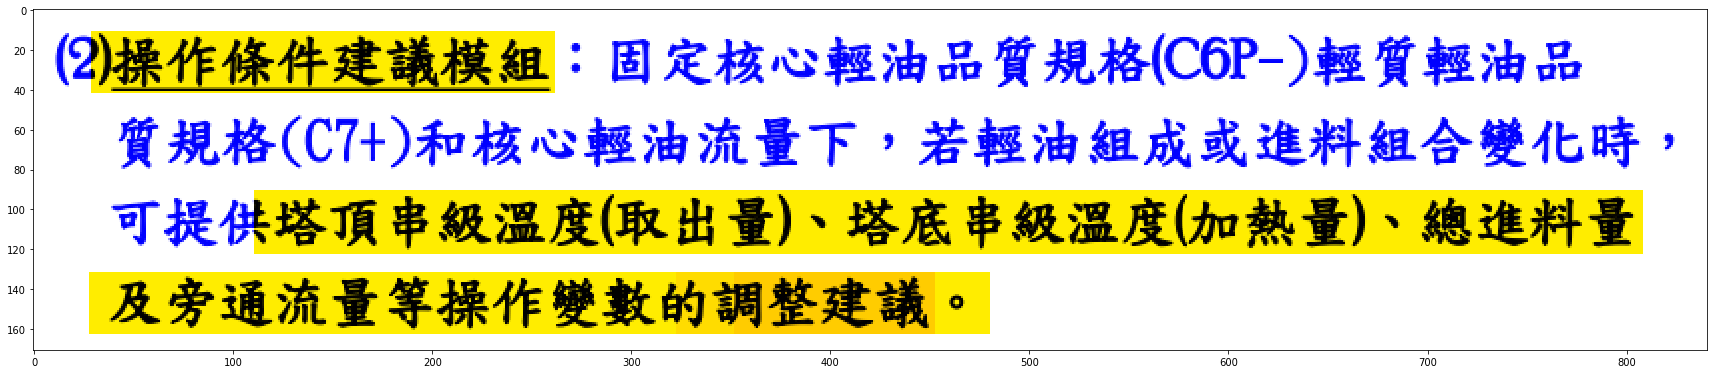

In [11]:
image = mpimg.imread("./img/操作建議模組.png")
plt.figure(figsize = (30,30))
plt.imshow(image)
plt.show()

In [12]:
def 操作建議模組(case,xna):
    '''
    input:case(品質規格),xna(進料組成)
    output:a(操作建議),h(組成),r(流量)
    '''
    
    # 預測162項產物
    分離係數 = m58_162.predict(case.join(xna))
    還原組成 = m162_162(xna,分離係數)
    
    # 根據"係數"計算"核心輕油佔比"
    shc = 分離係數[col_names['shc']].values
    xhc = 還原組成[col_names['xhc']].values
    核心輕油佔比 = ((xna.values@shc.T)/xhc.sum(axis=1)).ravel()[0]
    
    # 取得核心輕油產物
    核心輕油54 = 還原組成[col_names['xhc']]
    核心輕油23 = m54_23(核心輕油54)
    核心輕油33 = m54_33(核心輕油54)
    
    # 確保質量平衡
    assert np.allclose(核心輕油54.sum(axis=1).values[0],
                       核心輕油23.sum(axis=1).values[0],
                       核心輕油33.sum(axis=1).values[0])
    
    # 重組單元流程
    C6Pm = 核心輕油23[['C5NP','C5IP','C6IP','C6NP']].sum(axis=1)[0]
    NpA = 核心輕油23[['C5N','C6N','C7N','C8N','C9N','C10N','C6A','C7A','C8A','C9A','C10A']].sum(axis=1)[0]
    重組單元輸入 = [NpA,0.942,3.78,C6Pm,517,517,517,515]+核心輕油33.values.ravel().tolist()+[4.798,1.44]
    重組單元輸入 = pd.DataFrame(np.array(重組單元輸入).reshape(1,-1),columns=m43_33.x_col)
    重組單元輸出 = m43_33.predict(重組單元輸入)
    產品輸出 = m33_15(重組單元輸出) 
    
    # 模型c預測 操作建議(a) 和 流量(r)
    模型C輸出 = ANN_C.predict(case.join(xna))
    全質輕油入料_ton = 模型C輸出['Naphtha Properties_Naphtha Feed Rate_ton/hr'].values[0]
    模型B輸出 = ANN_B.predict(case.join(xna))
    加工成本 = 模型B輸出[['Duty_E062 3.5K Steam Rate_ton/hr','Duty_Reboiler Heat Duty_Mkcal/hr']]
    全質輕油密度 = 模型B輸出['NA_density'].values[0]
    全質輕油入料_m3 = 全質輕油入料_ton * (1/全質輕油密度)
    
    核心輕油出料 = 全質輕油入料_m3*核心輕油佔比
    
    產出物 = 產品輸出*核心輕油出料 #15項產出物
    加熱量 = 模型C輸出.iloc[:,:4] # 各項溫度調整建議
    流量 = 模型C輸出.iloc[:,4:] # 總進料量和(輕/重/回)流量數據
    
    # 因為有兩種方式計算這一項結果 確保兩種方式結果一致
    if (全質輕油入料_ton - 流量.iloc[:,0].values[0])**2 > 1e-12:
        print('error!')
    
    return 加熱量,產出物,流量,加工成本

In [13]:
F = 操作建議模組
加熱量,產物,流量,加工成本 = F(case,xna)

In [14]:
加熱量

,Duty_Condenser Heat Duty_Mkcal/hr,Duty_Reboiler Heat Duty_Mkcal/hr,Column Temp Profile_C011 Tray 15 Temp_oC,Column Temp Profile_C013 Tray 16 Temp_oC
0,4.568756,4.42339,105.614517,150.607513


In [15]:
產物

,HYD,NC1,NC2,NC3,PC4,SAP,SAN,BEZ,TOL,ETB,PXY,MXY,OXY,C9A,C10
0,402.770855,95.740862,370.155226,234.370591,509.092411,1757.583261,110.573261,482.027349,2821.713723,462.10791,429.873533,1221.864167,684.931985,1255.142898,194.806526


In [16]:
流量

,Naphtha Properties_Naphtha Feed Rate_ton/hr,Yield Summary_Reflux Rate_m3/hr,Yield Summary_Light End Prod. Rate_m3/hr,Yield Summary_Heavy End Prod. Rate_m3/hr
0,104.693207,44.090881,21.893072,9.015686


In [17]:
加工成本

,Duty_E062 3.5K Steam Rate_ton/hr,Duty_Reboiler Heat Duty_Mkcal/hr
0,2.6612,4.537329


# 產值估算模組

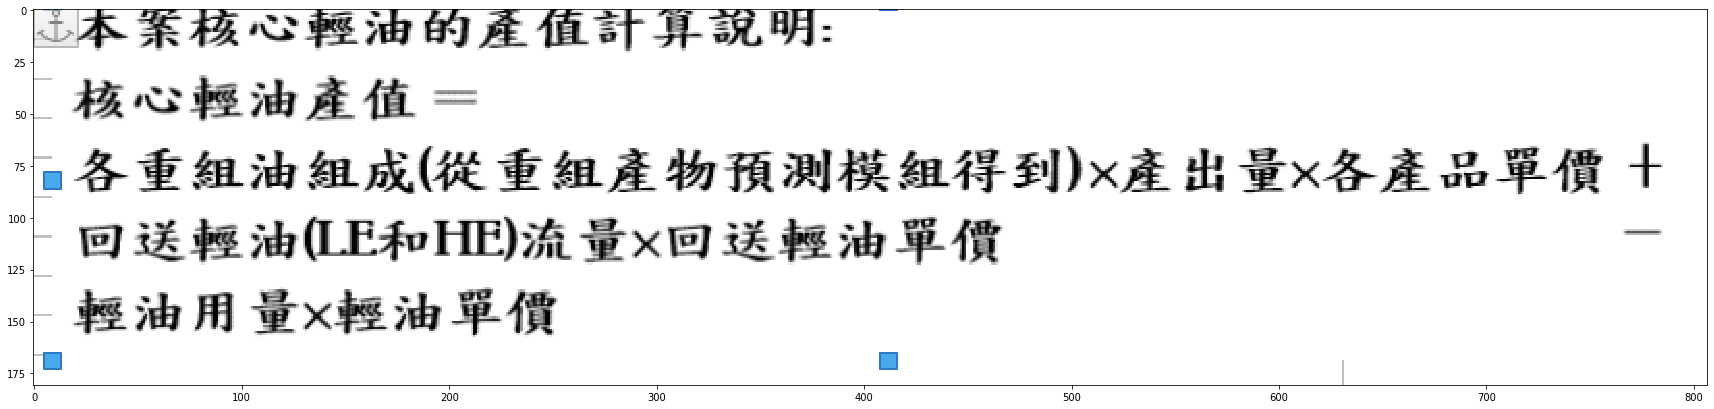

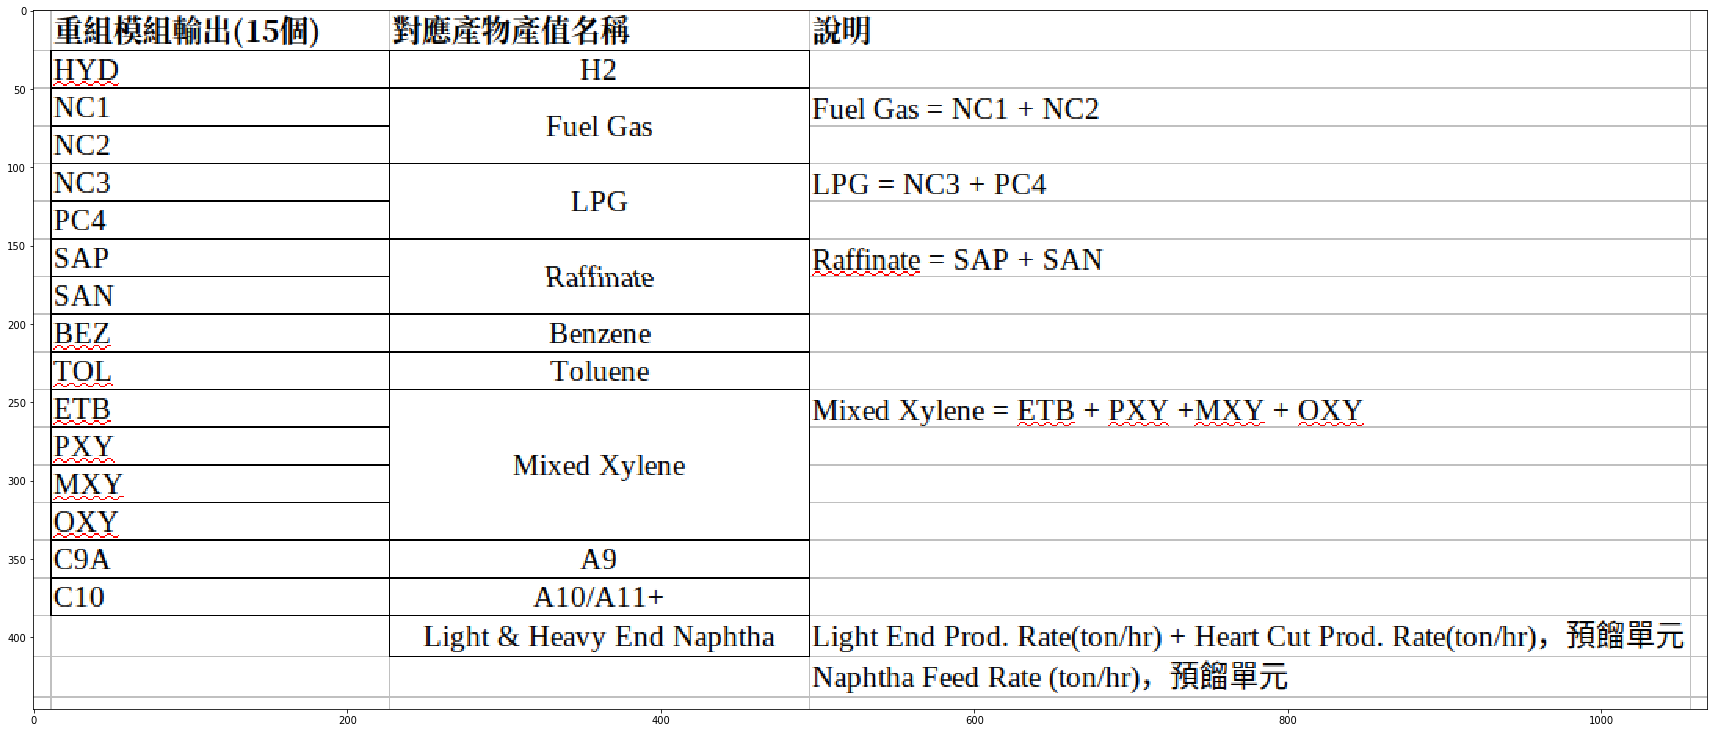

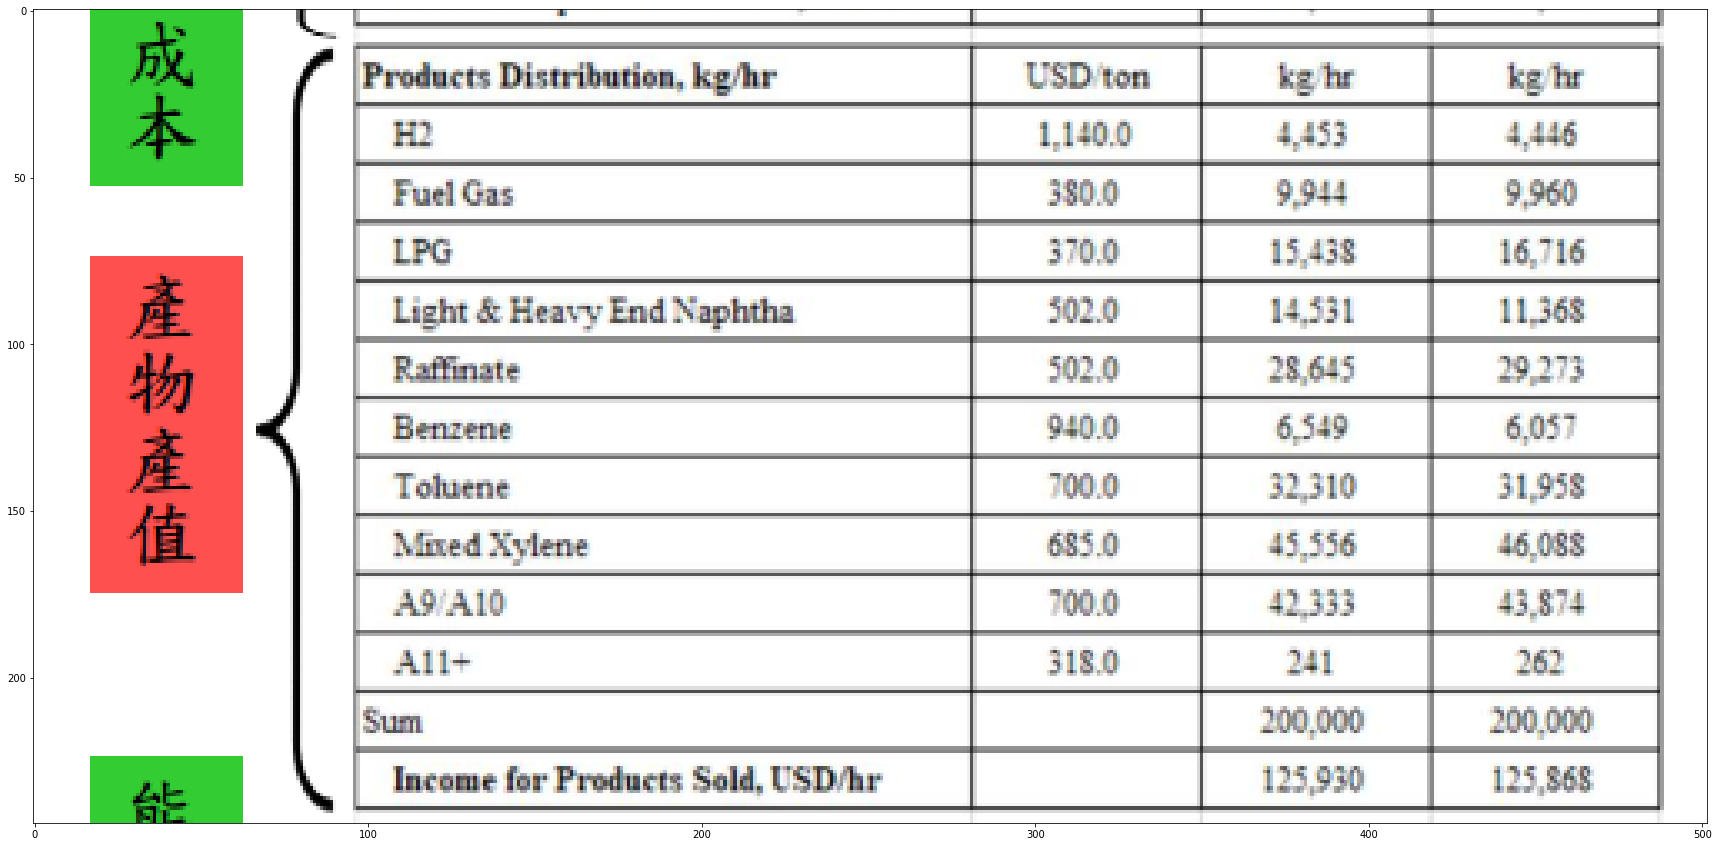

In [18]:
for i in range(3):
    image = mpimg.imread("./img/Price{}.png".format(i+1))
    plt.figure(figsize = (30,30))
    plt.imshow(image)
    plt.show()

In [19]:
class 產值估算模組:
    def __init__(self,各產品單價,回送輕油單價,輕油單價,加工成本單價):
        self.各產品單價 = 各產品單價
        self.回送輕油單價 = 回送輕油單價
        self.輕油單價 = 輕油單價
        self.加工成本單價 = 加工成本單價
    
    def __call__(self,各重組油組成,回送輕油流量,輕油用量,加工成本):
        total = 0
        total += (各重組油組成*self.各產品單價).sum() # (vector*vector).sum()
        total += 回送輕油流量*self.回送輕油單價 # scalar*scalar
        total -= 輕油用量*self.輕油單價 # scalar*scalar
        total -= (加工成本*self.加工成本單價).sum()#(vector*vector).sum()
        return total

In [20]:
各產品單價 = np.array([1140,380,380,370,370,502,502,940,700,685,685,685,685,700,318])
回送輕油單價 = 198.015
輕油單價 = 205.015
加工成本單價 = np.array([30,12])
Q = 產值估算模組(各產品單價,回送輕油單價,輕油單價,加工成本單價)

#  操作建議模組(F) + 產值估算模組(Q) = 操作優化模組

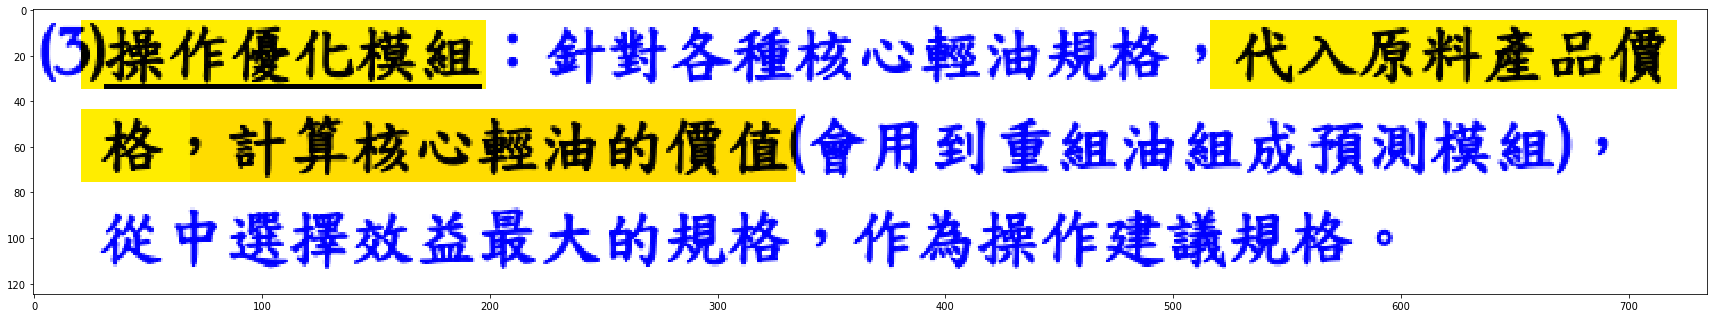

In [21]:
image = mpimg.imread("./img/操作優化模組.png")
plt.figure(figsize = (30,30))
plt.imshow(image)
plt.show()

In [22]:
class OperationOptimModel:
    def __init__(self,F,Q,case_list):
        self.case_list = case_list
        self.F = F
        self.Q = Q
    
    def get_advice(self,xna):
        fitness = []
        actions = []
        產物list = []
        流量list = []
        
        #對各種case遍歷取得a,h,r代入Q函數計算產值,返回最大產值對應的action
        print('產值計算中請稍等')
        for case in tqdm(self.case_list):
            
            # 使用操作建議模組取得 加熱建議a , 產物組成h , 流量r(入料量,回流量,輕流量,重流量)
            加熱量,產物,流量,加工成本 = self.F(case,xna)
            
            # 紀錄
            actions.append(加熱量)
            產物list.append(產物)
            流量list.append(流量)
            
            # 轉換成 numpy format
            回送流量 = 流量.iloc[:,-2:].sum(axis=1).values[0] # 輕＋重 ＝ 回送
            輕油用量 = 流量.iloc[:,0].values[0] # Fna 全質輕油用量
            產物 = 產物.values # 15項產物
            加工成本 = 加工成本.values # 模組b出來的兩項duty
            
            #代入估價模組計算產值
            產值 = self.Q(產物,回送流量,輕油用量,加工成本)
            fitness.append(產值)
        
        # 選擇效益最大的產值對應的 操作,case,產物,流量,產值, 以及所有產值
        best_idx = np.array(fitness).argmax()
        output = (actions[best_idx],
                  case_list[best_idx],
                  產物list[best_idx],
                  流量list[best_idx],
                  fitness[best_idx],
                  fitness)
        return output

In [23]:
agent = OperationOptimModel(F,Q,case_list)

In [24]:
best_action,best_case,best_產物,best_流量,best_value,values = agent.get_advice(xna)

產值計算中請稍等


In [25]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth',100)

temp = pd.DataFrame()
for i in agent.case_list:
    temp = temp.append(i)
temp

,Case Conditions_Feed Rate to C013 (Input)_m3/hr,Case Conditions_C7+ in Light End (Input)_wt%,Case Conditions_Heart Cut Prod. Rate (Input)_m3/hr,Case Conditions_C6P- in Heart Cut (Input)_wt%
323-17,10.0,2.5,90.0,1.0
323-17,10.0,2.5,100.0,1.0
323-17,10.0,2.5,110.0,1.0
323-17,20.0,2.5,90.0,1.0
323-17,20.0,2.5,100.0,1.0
323-17,20.0,2.5,110.0,1.0
323-17,30.0,2.5,90.0,1.0
323-17,30.0,2.5,100.0,1.0
323-17,30.0,2.5,110.0,1.0
323-17,10.0,5.0,90.0,1.0


In [26]:
#最優操作
best_action

,Duty_Condenser Heat Duty_Mkcal/hr,Duty_Reboiler Heat Duty_Mkcal/hr,Column Temp Profile_C011 Tray 15 Temp_oC,Column Temp Profile_C013 Tray 16 Temp_oC
0,5.554474,5.416958,97.288254,161.258591


In [27]:
#最優規格
best_case

,Case Conditions_Feed Rate to C013 (Input)_m3/hr,Case Conditions_C7+ in Light End (Input)_wt%,Case Conditions_Heart Cut Prod. Rate (Input)_m3/hr,Case Conditions_C6P- in Heart Cut (Input)_wt%
323-17,10.0,2.5,110.0,1.0


In [28]:
#最優產物
best_產物

,HYD,NC1,NC2,NC3,PC4,SAP,SAN,BEZ,TOL,ETB,PXY,MXY,OXY,C9A,C10
0,409.474117,96.545703,361.26395,235.607453,512.336828,1763.261678,108.667757,488.275912,2873.905593,469.728187,435.152184,1231.999029,694.815509,1260.245621,191.602922


In [29]:
#最優流量
best_流量

,Naphtha Properties_Naphtha Feed Rate_ton/hr,Yield Summary_Reflux Rate_m3/hr,Yield Summary_Light End Prod. Rate_m3/hr,Yield Summary_Heavy End Prod. Rate_m3/hr
0,105.034729,59.390644,20.866236,10.173678


In [30]:
#最大產值
round(best_value,2)

7195207.16

In [31]:
#所有產值
[round(i,2) for i in sorted(values)]

[5880672.32,
 5881758.22,
 5892082.81,
 5893387.16,
 5894994.81,
 5906860.67,
 5907017.15,
 5911098.22,
 5915048.76,
 5917741.72,
 5920411.35,
 5920940.94,
 5926974.04,
 5927298.5,
 5929879.06,
 5931758.7,
 5934639.96,
 5936695.62,
 5940129.38,
 5941187.98,
 5941203.89,
 5943495.03,
 5949916.08,
 5952031.99,
 5959009.24,
 5965063.81,
 5965848.66,
 6522532.7,
 6528841.51,
 6531129.74,
 6535392.14,
 6537145.12,
 6538534.32,
 6543911.35,
 6545158.7,
 6545909.38,
 6552965.56,
 6554390.53,
 6556122.32,
 6559331.62,
 6563587.39,
 6564231.85,
 6565994.99,
 6566101.92,
 6566874.44,
 6568487.77,
 6569876.07,
 6573746.0,
 6574626.78,
 6574981.96,
 6578838.62,
 6580010.75,
 6582690.88,
 6585928.55,
 7094361.3,
 7102774.25,
 7110363.17,
 7116778.44,
 7119296.68,
 7119634.08,
 7126295.63,
 7133946.78,
 7138555.19,
 7139934.02,
 7145121.93,
 7147047.1,
 7152793.02,
 7152881.42,
 7158226.24,
 7160126.83,
 7161285.88,
 7161986.23,
 7163131.08,
 7163399.12,
 7164053.5,
 7180076.29,
 7182266.38,
 718273

In [32]:
import joblib

path = './model/OperationOptimModel.pkl'
joblib.dump(agent,path)
print('save done!')

save done!
